In [19]:
import optuna
import logging
import warnings

import warnings
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

logger = logging.getLogger()

logger.setLevel(logging.INFO)  # Setup the root logger.
logger.addHandler(logging.FileHandler("./cache/optuna.log", mode="w"))

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

base_path = './prod/all'

def get_study(name):
    # create or load the study
    study = optuna.study.create_study(
        storage=f'sqlite:///{base_path}/cache/optuna.db',
        load_if_exists=True,
        directions=['maximize', 'minimize'],
        study_name=name,
        sampler=optuna.samplers.TPESampler(n_startup_trials=150),
        pruner=optuna.pruners.MedianPruner()
    )
    study.set_metric_names(['r2', 'mse'])
    return study


In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Set sklearn output to pandas dataframes
from sklearn import set_config
set_config(transform_output='pandas')

# Select Variables

In [21]:
from src.selectvar import get_data

data, variables = get_data(window=7)
print(f'Mean before subsampling: {data["tavg"].mean()}')

# Filter data
data = data[(data['pmonin'] <= 9) & (data['pmonin'] >= 5)]
print(f'Mean after subsampling: {data["tavg"].mean()}')

Mean before subsampling: 7.86109599611841
Mean after subsampling: 16.03297287402342


In [22]:
# interpolate
data.sort_values(by=['pid', 'syear'], inplace=True)
data = data.groupby('pid').bfill(1).reset_index(names='pid')

In [23]:
def remove_duplicate_prefixes(strings):
    selected_strings = []
    removed_strings = []
    seen_prefixes = set()
    for string in strings:
        prefix = string.split('_')[0]
        if prefix not in seen_prefixes:
            seen_prefixes.add(prefix)
            selected_strings.append(string)
        else:
            removed_strings.append(string)
    return removed_strings

def get_category(cat):
    return variables.loc['category', variables.loc['category',:] == cat].index.tolist()

def get_type(typ):
    return variables.loc['type', variables.loc['type',:] == typ].index.tolist()

# Manuall dropping of variables (very clear cases)
columns_to_drop = [
    'fweight', 'fheight', 'valid', # imputation flags
    'pcs', 'mcs', #pca of other variables
    'plj0151'
]
columns_to_drop += get_category('key')
columns_to_drop += remove_duplicate_prefixes(data.columns)

data.drop(columns=columns_to_drop, inplace=True)
variables.drop(columns=columns_to_drop, inplace=True)

# mark nan
data[data<0] = np.nan

# get target
variables.drop(columns='plh0182', inplace=True)
y = data.pop('plh0182')

print(f'There are {data.shape[0]} rows in the data')

There are 156492 rows in the data


In [24]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# do pca transform for all categories
transformers = []

for typ in tqdm(variables.loc['type',:].unique()):
    # Get subset of data in that category
    vars = get_type(typ)

    if typ == 'Nominal':
        vars_keep = [v for v in vars if len(data.loc[:,v].unique()) < 20]
        transformers.append((typ, OneHotEncoder(sparse_output=False, ), vars_keep))
        vars_drop = [v for v in vars if len(data.loc[:,v].unique()) >= 20]
        transformers.append(('High Cardinality', 'drop', vars_drop))
    elif typ == 'Ordinal':
        transformers.append((typ, StandardScaler(), vars))
    elif typ == 'Discrete':
        transformers.append((typ, StandardScaler(), vars))
    else:
        transformers.append((typ, StandardScaler(), vars))
transformers.append(('Weather', StandardScaler(), ['prcp', 'tsun', 'wspd', 'pres', 'tavg']))

100%|██████████| 4/4 [00:00<00:00, 62.33it/s]


In [25]:
from sklearn.compose import ColumnTransformer

# define the transformers
transformer = ColumnTransformer(
    transformers, remainder='drop'
)
transformer

ColumnTransformer(transformers=[('Discrete', StandardScaler(),
                                 ['syear', 'ple0010_h']),
                                ('Nominal', OneHotEncoder(sparse_output=False),
                                 ['pla0009_v2', 'plb0018', 'plb0019_v2',
                                  'plb0021', 'plb0022_h', 'plb0024_v3',
                                  'plb0282_h', 'pld0131_v1', 'ple0040',
                                  'ple0053', 'ple0097', 'ple0160', 'plg0012_v1',
                                  'plg0072', 'plh0011_h', 'plj0014_v3',
                                  'plj0022', 'pinta_v2', 'pmonin', 'h_pn...
                                ('Continuous', StandardScaler(),
                                 ['pli0038_h', 'pli0040', 'pli0043_h',
                                  'pli0044_h', 'pli0046', 'pli0047_v1',
                                  'pli0049_h', 'pli0051', 'age', 'pf_nbs',
                                  'rp_nbs', 'bp_nbs', 'gh_nbs', 'vt_nbs',
                                  'sf_nbs', 're_nbs', 'mh_nbs', 'bmi', 'height',
                                  'weight', 'hlc0005_h', 'hlf0019_h',
                                  'hlf0021_h', 'prcp', 'tsun', 'wspd', 'pres',
                                  'tavg']),
                                ('Weather', StandardScaler(),
                                 ['prcp', 'tsun', 'wspd', 'pres', 'tavg'])])

In [26]:
# Transform data
transformer.fit(data)
X = transformer.transform(data)

X['target'] = y
X.dropna(inplace=True)
y = X.pop('target')

print(f'There are {X.shape[0]} remaining rows in the data.')

There are 44457 remaining rows in the data.


In [27]:
from sklearn.model_selection import train_test_split

results_mean = []
results_median = []
for i in tqdm(range(2_000)):
    y_train, y_test = train_test_split(y, test_size=0.33)
    y_pred = np.mean(y_train)
    results_mean.append((y_train - y_pred)**2)
    y_pred = np.median(y_train)
    results_median.append((y_test - y_pred)**2)

print(f'The average mean squared error of the mean predictor is: {np.mean(results_mean)}.')
print(f'The std mean squared error of the mean predictor is: {np.std(results_mean)}.', end='\n\n')

print(f'The average mean squared error of the median predictor is: {np.mean(results_median)}.')
print(f'The std mean squared error of the median predictor is: {np.std(results_median)}.')

100%|██████████| 2000/2000 [00:02<00:00, 782.75it/s]


The average mean squared error of the mean predictor is: 2.8863720008559306.
The std mean squared error of the mean predictor is: 5.444944690092704.

The average mean squared error of the median predictor is: 3.326826630768182.
The std mean squared error of the median predictor is: 6.960493462044216.


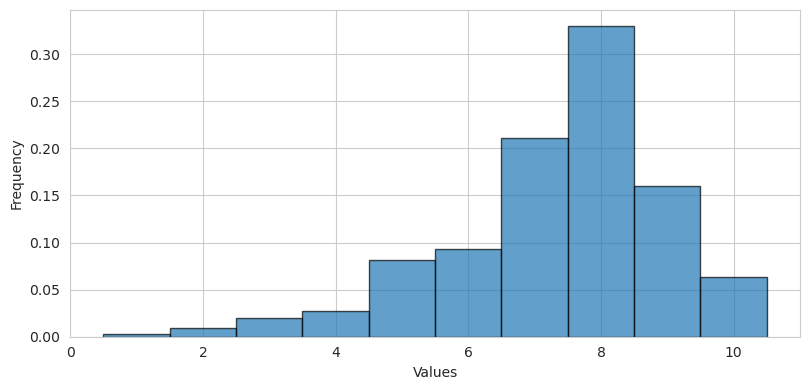

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(8.2, 4))

# Create the histogram
ax.hist(y, bins=np.arange(0.5, 11.5, 1), density=True, edgecolor="k", alpha=0.7)

# Add labels
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(f'{base_path}/plots/dist_target.pdf', dpi=300)

In [29]:
from sklearn.model_selection import StratifiedKFold

custom_cv = StratifiedKFold(n_splits=5, shuffle=True)

In [30]:
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Objective function for hp tuning
def objective(trial, est, suggestor):
    # suggest params
    params = suggestor(trial)
    est.set_params(**params)
    # suggest number of principle components
    r2_scores, mse_scores = [], []
    for train_idx, test_idx in custom_cv.split(X, y):
        # fit estimator
        est = est.fit(X.iloc[train_idx], y.iloc[train_idx])
        # predict test set
        y_pred = est.predict(X.iloc[test_idx])
        y_true = y.iloc[test_idx]
        # compute the performance
        r2_scores.append(r2_score(y_true, y_pred))
        mse_scores.append(mean_squared_error(y_true, y_pred))
    return np.mean(r2_scores), np.mean(mse_scores)

############################
############################

# Suggesting functions for each model
def hb_suggestor(t):
    t.suggest_int('max_iter', 1, 1001, 10)
    t.suggest_int('max_depth', 3, 20, 1)
    t.suggest_int('min_samples_leaf', 10, 400, step=10)
    t.suggest_float('l2_regularization', 0.001, 100, log=True)
    return t.params

def sgd_suggestor(t):
    t.suggest_float('alpha', 1e-4, 1e-1, log=True)
    t.suggest_float('epsilon', 1e-2, 0.1)
    t.suggest_categorical('loss', ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error', 'huber'])
    t.suggest_categorical('penalty', ["l2", "l1", "elasticnet"])
    return t.params

def rf_suggestor(t):
    t.suggest_int('max_depth', 1, 40, 1)
    t.suggest_int('min_samples_split', 10, 500, 10)
    t.suggest_int('min_samples_leaf', 10, 500, 10)
    t.suggest_float('max_features', 0.001, 1)
    return t.params

############################
############################

# Define the models to optimize
hb = HistGradientBoostingRegressor(
    learning_rate=0.01, early_stopping=True
)
sgd = SGDRegressor(max_iter=20_000)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, bootstrap=True)

models = [
    ('Random Forest Regressor', rf, rf_suggestor),
    ('Hist Gradient Boosting Regressor', hb, hb_suggestor),
    ('Stochastic Gradient Descent', sgd, sgd_suggestor)
]

for name, model, func in models:
    study = get_study(name)
    study.optimize(lambda x: objective(x, model, func), timeout=60*60, n_trials=0)

In [31]:
# Set best parameters
rf_best_param = {
    'max_depth': 11, 
    'max_features': 0.5902650070608875, 
    'min_samples_leaf': 20, 
    'min_samples_split': 10
}
rf.set_params(**rf_best_param)
rf.fit(X, y)

hb_best_param = {
    'l2_regularization':2.0392399957480034,
    'max_depth':14,
    'max_iter':741,
    'min_samples_leaf':170
}
hb.set_params(**hb_best_param)
hb.fit(X, y)

sgd_best_param = {
    'alpha':0.0003011586651846917,
    'epsilon':0.08247039786190892,
    'loss':'squared_error',
    'penalty':'l1'
}
sgd.set_params(**sgd_best_param)
sgd.fit(X, y)

SGDRegressor(alpha=0.0003011586651846917, epsilon=0.08247039786190892,
             max_iter=20000, penalty='l1')

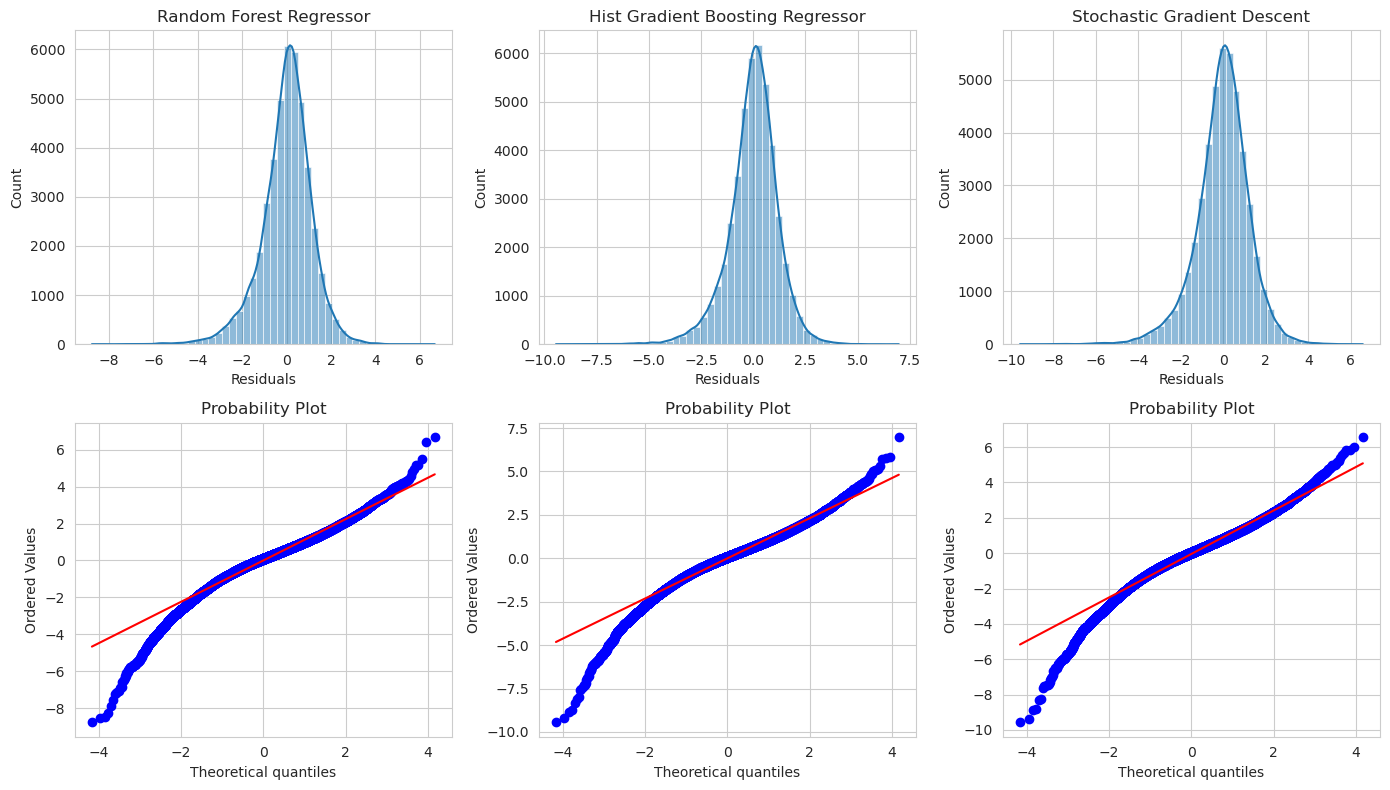

In [32]:
import scipy.stats as stats

fig, axs = plt.subplots(2, 3, sharey=False, figsize=(14, 8))
for i, (name, model, _) in enumerate(models):
    # Calculate residuals
    residuals = y - model.predict(X)
    
    # Create a histogram
    sns.histplot(residuals, kde=True, bins=50, ax=axs[0, i])
    axs[0, i].set_xlabel('Residuals')
    axs[0, i].set_title(name)

    # Create QQ plot
    stats.probplot(residuals, plot=axs[1, i])

plt.tight_layout()
plt.show()

In [33]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

# make a bootstrap sampler
n_splits = 10
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty dataframe to store the results
score_result_df = pd.DataFrame()
importance_df = pd.DataFrame()

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X, y), total=n_splits):
    # Get train part of bootstrap
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    for name, model, func in models:
        # train all models
        model.fit(X_train, y_train)

        # Check how well the model is performing
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate R2
        score_test = r2_score(y_test, y_pred_test)
        score_train = r2_score(y_train, y_pred_train)
        # Calculate Mean Squared Error (MSE)
        mse_test = mean_squared_error(y_test, y_pred_test)
        mse_train = mean_squared_error(y_train, y_pred_train)

        # Save
        score_result_df = pd.concat(
            [score_result_df, pd.DataFrame({
                'r2': [score_test, score_train], 
                'mse':[mse_test, mse_train],
                'test': [True, False], 
                'model':[name, name]
            })], 
            axis=0
        )

        # Perform permutation importance
        result = permutation_importance(
            model, X_train, y_train, scoring='r2', n_repeats=1
        )
        temp = pd.DataFrame({
            'features': X.columns,
            'importance_mean': result['importances_mean'],
            'importance_std': result['importances_std'],
            'model':name
        })
        importance_df = pd.concat([importance_df, temp], axis=0)


# Save dataframes
score_result_df.to_csv(f"{base_path}/tables/score_results.csv", index=False)
importance_df.to_csv(f"{base_path}/tables/importance_results.csv", index=False)

100%|██████████| 10/10 [24:01<00:00, 144.12s/it]


In [36]:
cutoff = 0.0025

# Aggregate permutation importance scores across all cross-validation folds for each feature and model
filtered_importance = importance_df.groupby(['features', 'model']).mean().reset_index().\
                            groupby('features').\
                            filter(lambda x: np.sum(x['importance_mean'] >= cutoff) >= 2).\
                            reset_index()

selected_features = filtered_importance['features'].unique()
selected_features

array(['Continuous__gh_nbs', 'Continuous__mh_nbs',
       'Continuous__pli0044_h', 'Continuous__re_nbs',
       'Continuous__rp_nbs', 'Continuous__sf_nbs', 'Continuous__vt_nbs',
       'Discrete__ple0010_h', 'Discrete__syear', 'Nominal__hlk0056_9.0',
       'Nominal__pld0131_v1_1.0', 'Ordinal__ple0008', 'Ordinal__plh0033',
       'Ordinal__plh0171', 'Ordinal__plh0175', 'Ordinal__plh0177',
       'Ordinal__plh0178'], dtype=object)